# RANDOM FOREST GBDT ALGORITHM on Amazon Fine Food Reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

  ## Loading,Cleaning & Preprocessing the data

  The dataset is available in two forms
  1. .csv file
  2. SQLite Database

  In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
  <br> 

  Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
con = sqlite3.connect("/content/drive/My Drive/Colab Notebooks/database.sqlite")

filtered_data=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""",con);
filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
filtered_data.shape

def partition(x):
  if x < 3 :
    return 'negative'
  return 'positive'

actualScore=filtered_data['Score']
positive_negative=actualScore.map(partition)
filtered_data['Score']=positive_negative
print("Number of datapoints",filtered_data.shape)
filtered_data.head(3)

Number of datapoints (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head(3)

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2


In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [8]:
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')

final_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
final_data.shape

(364173, 10)

In [9]:
(final_data['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final_data=final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
stopping_words = set(stopwords.words('english'))
print(stopping_words)

{'y', "mustn't", 'you', 'other', 'ours', 'hadn', "wouldn't", 'during', 'through', "you've", "hadn't", 'she', 'aren', 'his', 'their', 'we', 'under', 'a', 'themselves', 'my', 'for', 'only', "you're", 'very', "shan't", 'm', 'isn', 'in', 'here', 'about', 'own', 'wasn', "wasn't", 'from', 'all', 'at', 'shan', 'some', 'until', 'an', 'weren', 're', 'yourself', 'with', 'your', 'and', 'who', 'what', 'or', 'our', 'will', 'doesn', 'do', 'its', 'couldn', 'just', 'more', 'it', 'don', 'being', 'should', 'by', 'myself', 'hasn', "she's", 'have', 'has', 'itself', 'was', 'off', 'as', 'both', 'o', 'most', 'him', 'any', 'against', 'can', 'of', 'needn', 'to', 'himself', 'did', 'wouldn', "hasn't", 'before', 'ourselves', "you'll", 'on', 'mightn', 't', 'out', 'he', 'the', 'having', 'over', "won't", 'shouldn', 'these', 'where', 'again', 'too', 'so', 'further', 'd', 'down', 'haven', 'now', "doesn't", "you'd", "didn't", 'were', 'above', 'why', 'which', "needn't", 'hers', 'this', 'they', 'does', 'there', 'each', '

In [0]:
def clean_html(text):
    clean_r = re.compile('<,*?>')
    clean_text = re.sub(clean_r,'',text)
    return clean_text

def Clean_punc(text):
    clean_sentence = re.sub(r'[?|!|\'|"|#]',r' ',text)
    clean_data = re.sub(r'[.|,|)|(|\|/)]',r' ',clean_sentence)
    return clean_data

In [15]:
from tqdm import tqdm
import os
import pdb
import pickle

from tqdm import tqdm
import os
import pdb
import pickle

stem_no = nltk.stem.SnowballStemmer('english')

if not os.path.isfile('final_data.sqlite'):
    final_string=[]
    all_positive_words=[]
    all_negative_words=[]
    for i,sentence in enumerate(tqdm(final_data['Text'].values)):
        filtered_sentence=[]
        sent_without_html_tags=clean_html(sentence)
        #pdb.set_trace()
        for w in sent_without_html_tags.split():
            for cleaned_words in Clean_punc(w).split():
                if ((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):
                    if(cleaned_words.lower() not in stopping_words) :
                        stemming=(stem_no.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(stemming)
                        if(final_data['Score'].values)[i]=='positive':
                            all_positive_words.append(stemming)
                        if(final_data['Score'].values)[i]=='negative':
                            all_negative_words.append(stemming)
        str1 = b" ".join(filtered_sentence)
        final_string.append(str1)
        
    final_data['Cleaned_text']=final_string
    final_data['Cleaned_text']=final_data['Cleaned_text'].str.decode("utf-8")    
    
    conn = sqlite3.connect('final_data.sqlite')
    cursor=conn.cursor
    conn.text_factory = str
    final_data.to_sql('Reviews',conn,schema=None,if_exists='replace',index=True,index_label=None,chunksize=None,dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl','wb') as f :
        pickle.dump(all_positive_words,f)
    with open('negative_words.pkl','wb') as f :
        pickle.dump(all_negative_words,f)

100%|██████████| 364171/364171 [05:47<00:00, 1048.66it/s]


In [0]:
final_data['total_words'] = [len(x.split()) for x in final_data['Cleaned_text'].tolist()]

In [0]:
final_data.sort_values(by=['Time'], inplace=True, ascending=True)

In [18]:
final_data['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [0]:
count_positive,count_negative=final_data['Score'].value_counts()

In [0]:
final_data_positive_class=final_data[final_data['Score']=='positive']
final_data_negative_class=final_data[final_data['Score']=='negative']

## RANDOM UP SAMPLING

### Note : In Up Sampling , there will be duplicate random records from the minority class which can cause overfitting

In [0]:
#final_data_negative=final_data_negative_class.sample(count_positive,replace=True)
#final_data_after_Sampling=pd.concat([final_data_positive_class,final_data_negative], axis=0 )
final_data_positive=final_data_positive_class.sample(count_negative)

fina_data_after_Sampling=pd.concat([final_data_positive,final_data_negative_class], axis=0)

In [22]:
fina_data_after_Sampling['Score'].value_counts()

negative    57110
positive    57110
Name: Score, dtype: int64

In [23]:
fina_data_after_Sampling.shape

(114220, 12)

In [24]:
final_data_100K=fina_data_after_Sampling[0:100000]
amazon_polarity_labels=final_data_100K['Score'].values
final_data_100K.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text,total_words
134333,145807,B003D4F1QS,A1XU4U4159OFXD,Liz,2,2,positive,1327622400,Yum!,"Delicious Tea, not too bitter but with a nice ...",delici tea bitter nice strong tast foil packet...,25
455421,492385,B000F9ZDKI,AYCLRXW5VOIOQ,"penny pincher ""two cents""",13,13,positive,1260489600,great alternative side dish,"I've always enjoyed couscous, but I never trie...",alway enjoy couscous never tri pearl version w...,86


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

X_1,X_Test,Y_1,Y_Test = train_test_split(final_data_100K,amazon_polarity_labels,test_size=0.2,random_state=0)
X_Train,X_CV,Y_Train,Y_CV = train_test_split(X_1,Y_1,test_size=0.2)

# **RANDOM FOREST ALGORITHM**

## APPLY BAG OF WORDS VECTORIZATION TECHNIQUE USING RANDOM FOREST TO FIND THE BEST HYPERPARAMETER

In [27]:
print(X_Train.shape, Y_Train.shape)
print(X_CV.shape, Y_CV.shape)
print(X_Test.shape, Y_Test.shape)

print("="*100)


count_vector=CountVectorizer(min_df=1)
X_Train_data_bow=(count_vector.fit_transform(X_Train['Cleaned_text'].values))
X_Test_data_bow=(count_vector.transform(X_Test['Cleaned_text'].values))
X_CV_data_bow=(count_vector.transform(X_CV['Cleaned_text'].values))

print("After vectorizations")
print(X_Train_data_bow.shape, Y_Train.shape)
print(X_CV_data_bow.shape, Y_CV.shape)
print(X_Test_data_bow.shape, Y_Test.shape)
print("="*100)

(64000, 12) (64000,)
(16000, 12) (16000,)
(20000, 12) (20000,)
After vectorizations
(64000, 30318) (64000,)
(16000, 30318) (16000,)
(20000, 30318) (20000,)


In [0]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

max_depth = [1,5,10,50,100,500,1000]
n_estimators =  [20,40,60,80,100] 
def Random_Forest_Classifier(x_training_data,y_training_data,x_cv_training,y_cv_training):
  grid_params = { 'max_depth' : max_depth,
                   'n_estimators' : n_estimators           
                 }
  Classifier_RFT = RandomForestClassifier(random_state=None, class_weight ='balanced',oob_score=True)
  clf=GridSearchCV(Classifier_RFT,grid_params,scoring='roc_auc',return_train_score=True,cv=3,n_jobs=-1)
  clf.fit(x_training_data,y_training_data)
  results = pd.DataFrame.from_dict(clf.cv_results_)
  results = results.sort_values(['param_max_depth'])
  results = results.sort_values(['param_n_estimators'])
  train_auc= results['mean_train_score']
  train_auc_std= results['std_train_score']
  cv_auc = results['mean_test_score'] 
  cv_auc_std= results['std_test_score']
  best_depth =  results['param_max_depth']  
  best_estimators =  results['param_n_estimators']  
  #log_alpha=np.log10(list(results["param_alpha"]))
  print(clf.best_score_)
  print(clf.best_params_)
  Build_HeatMap(max_depth,n_estimators,x_training_data,y_training_data,x_cv_training,y_cv_training)
  return results,clf,Classifier_RFT

In [0]:
import seaborn as sns
from sklearn.metrics import roc_auc_score

def Build_HeatMap(max_depth,n_estimators,X_Train,Y_Train,X_CV,Y_CV) :
  base_learner= []
  depths =[]
  auc_score_cv =[]  
  for i in n_estimators :
    for j in max_depth :
      RFClassifier=RandomForestClassifier(random_state=None, class_weight ='balanced',max_depth = j,n_estimators = i)
      RFClassifier.fit(X_Train,Y_Train)
      predict_cv=RFClassifier.predict_proba(X_CV)[:,1]
      predict_train=RFClassifier.predict_proba(X_Train)[:,1]
      base_learner.append(i)
      depths.append(j)
      auc_score_cv.append(roc_auc_score(Y_CV,predict_cv))      
  data_frame = pd.DataFrame({'n_estimators': base_learner, 'max_depth': depths, 'AUC': auc_score_cv})
  data_pivoted = data_frame.pivot("n_estimators", "max_depth", "AUC")
  heat_map = sns.heatmap(data_pivoted,annot=True)
  plt.title('Heatmap for cross validation data')
  plt.show()  

-------------BEST DEPTH USING DIFFERENT RANGE OF ESTIMATORS
0.9299056267764548
{'max_depth': 100, 'n_estimators': 100}


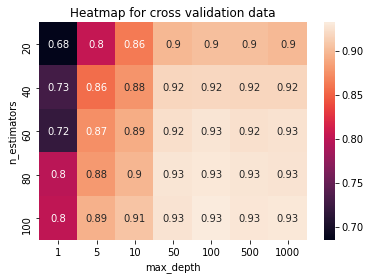

In [0]:
print ('-------------BEST DEPTH USING DIFFERENT RANGE OF ESTIMATORS')
result,best_depth,RF_Classiier=Random_Forest_Classifier(X_Train_data_bow,Y_Train,X_CV_data_bow,Y_CV)

In [0]:
def Find_best_Depth_estimator(best_depth,best_estimators) :
  best_depth = best_depth.best_params_
  best_estimators = best_estimators.best_params_  
  best_depth=best_depth.get("max_depth")
  best_estimators = best_estimators.get("n_estimators")  
  print(best_depth)
  print(best_estimators)
  return best_depth,best_estimators

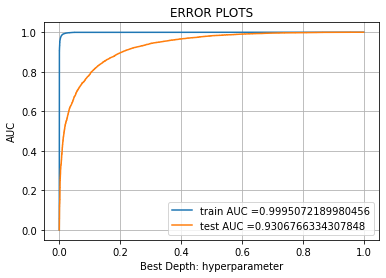

In [0]:
from sklearn.metrics import roc_curve, auc

RFClassifier= RandomForestClassifier(random_state=None, class_weight ='balanced',max_depth = 100,n_estimators = 100)
clf=RFClassifier.fit(X_Train_data_bow,Y_Train)
pred_test_data=RFClassifier.predict(X_Test_data_bow)
y_train_predicted_prob = RFClassifier.predict_proba(X_Train_data_bow)[:,1]
y_test_predicted_prob=RFClassifier.predict_proba(X_Test_data_bow)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test, y_test_predicted_prob,pos_label='positive')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Best Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [0]:
pip install WordCloud

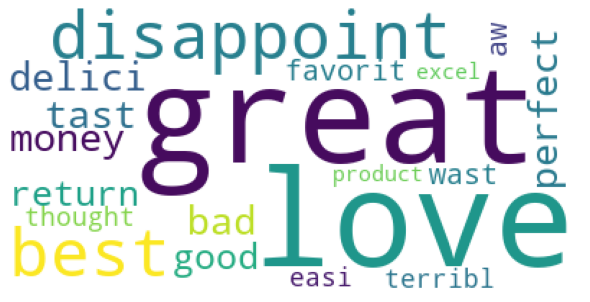

In [0]:
feature_names = count_vector.get_feature_names()
display_data=''
coef=RFClassifier.feature_importances_
features=np.argsort(coef)[::-1] 

for i in features[0:20]:
  display_data+=feature_names[i]
  display_data+=' '

from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white').generate(display_data)
plt.figure(figsize=(8,8),facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()

## TF-IDF VECTORIZATION TECHNIQUE USING RANDOM FOREST TO FIND THE BEST HYPERPARAMETER

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

print(X_Train.shape, Y_Train.shape)
print(X_CV.shape, Y_CV.shape)
print(X_Test.shape, Y_Test.shape)

print("="*100)


tfidf_vector=TfidfVectorizer(min_df=10)
X_Train_data_tfidf=(tfidf_vector.fit_transform(X_Train['Cleaned_text'].values))
X_Test_data_tfidf=(tfidf_vector.transform(X_Test['Cleaned_text'].values))
X_CV_data_tfidf=(tfidf_vector.transform(X_CV['Cleaned_text'].values))

print("After vectorizations")
print(X_Train_data_tfidf.shape, Y_Train.shape)
print(X_CV_data_tfidf.shape, Y_CV.shape)
print(X_Test_data_tfidf.shape, Y_Test.shape)
print("="*100)

(64000, 12) (64000,)
(16000, 12) (16000,)
(20000, 12) (20000,)
After vectorizations
(64000, 6990) (64000,)
(16000, 6990) (16000,)
(20000, 6990) (20000,)


-------------BEST DEPTH USING DIFFERENT RANGE OF ESTIMATORS
0.9265478624970153
{'max_depth': 100, 'n_estimators': 100}


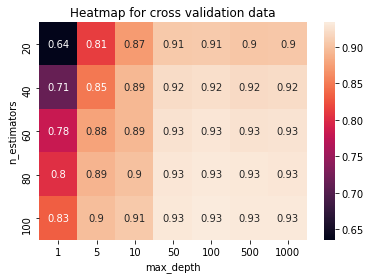

In [0]:
print ('-------------BEST DEPTH USING DIFFERENT RANGE OF ESTIMATORS')
result,best_depth,RF_Classiier=Random_Forest_Classifier(X_Train_data_tfidf,Y_Train,X_CV_data_tfidf,Y_CV)

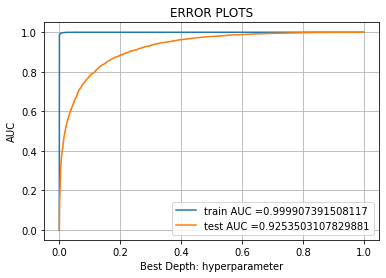

In [0]:
RFClassifier= RandomForestClassifier(random_state=None, class_weight ='balanced',max_depth = 100,n_estimators = 100)
clf=RFClassifier.fit(X_Train_data_tfidf,Y_Train)
pred_test_data=RFClassifier.predict(X_Test_data_tfidf)
y_train_predicted_prob = RFClassifier.predict_proba(X_Train_data_tfidf)[:,1]
y_test_predicted_prob=RFClassifier.predict_proba(X_Test_data_tfidf)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test, y_test_predicted_prob,pos_label='positive')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Best Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

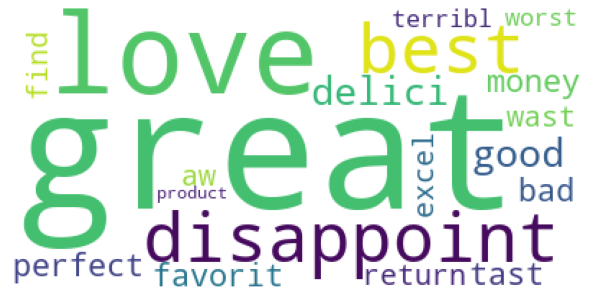

In [0]:
feature_names = tfidf_vector.get_feature_names()
display_data=''
coef=RFClassifier.feature_importances_
features=np.argsort(coef)[::-1] 

for i in features[0:20]:
  display_data+=feature_names[i]
  display_data+=' '

from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white').generate(display_data)
plt.figure(figsize=(8,8),facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()

## Avg Word2Vec Vectorization Technique using Random Forest 

In [33]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

list_of_sent_train_avgw2v=[]
list_of_sent_test_avgw2v=[]
list_of_sent_cv_avgw2v=[]
for sent_train_avgw2v in tqdm(X_Train['Cleaned_text'].values):
    list_of_sent_train_avgw2v.append(sent_train_avgw2v.split())

100%|██████████| 64000/64000 [00:01<00:00, 36198.00it/s]


In [34]:
for sent_test_avgw2v in tqdm(X_Test['Cleaned_text'].values):
    list_of_sent_test_avgw2v.append(sent_test_avgw2v.split())
    
for sent_cv_avgw2v in tqdm(X_CV['Cleaned_text'].values):
    list_of_sent_cv_avgw2v.append(sent_cv_avgw2v.split())

100%|██████████| 16000/16000 [00:00<00:00, 139946.29it/s]


In [0]:
w2v_model_train = Word2Vec(list_of_sent_train_avgw2v,min_count=5,size=50,workers=4)
w2v_words_svm_train=list(w2v_model_train.wv.vocab)

In [0]:
w2v_model_test = Word2Vec(list_of_sent_test_avgw2v,min_count=5,size=50,workers=4)
w2v_words_svm_test=list(w2v_model_test.wv.vocab)

In [0]:
w2v_model_cv = Word2Vec(list_of_sent_cv_avgw2v,min_count=5,size=50,workers=4)
w2v_words_svm_cv=list(w2v_model_cv.wv.vocab)

In [38]:
train_vectors=[];
for sent in list_of_sent_train_avgw2v:
    sent_vec=np.zeros(50)
    cnt_words=0;
    for word in sent:
        if word in w2v_words_svm_train:
            vec=w2v_model_train.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words !=0:
        sent_vec/=cnt_words
    train_vectors.append(sent_vec)
print(len(train_vectors))
print(len(train_vectors[0]))

64000
50


In [39]:
test_vectors=[];
for sent in tqdm(list_of_sent_test_avgw2v):
    sent_vec=np.zeros(50)
    cnt_words=0;
    for word in sent:
        if word in w2v_words_svm_test:
            vec=w2v_model_test.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words !=0:
        sent_vec/=cnt_words
    test_vectors.append(sent_vec)
print(len(test_vectors))
print(len(test_vectors[0]))

100%|██████████| 20000/20000 [00:16<00:00, 1210.51it/s]

20000
50


In [40]:
cv_vectors=[];
for sent in tqdm(list_of_sent_cv_avgw2v):
    sent_vec=np.zeros(50)
    cnt_words=0;
    for word in sent:
        if word in w2v_words_svm_cv:
            vec=w2v_model_cv.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words !=0:
        sent_vec/=cnt_words
    cv_vectors.append(sent_vec)
print(len(cv_vectors))
print(len(cv_vectors[0]))

100%|██████████| 16000/16000 [00:12<00:00, 1241.77it/s]

16000
50


-------------BEST DEPTH USING DIFFERENT RANGE OF ESTIMATORS
0.9072753950284099
{'max_depth': 50, 'n_estimators': 100}


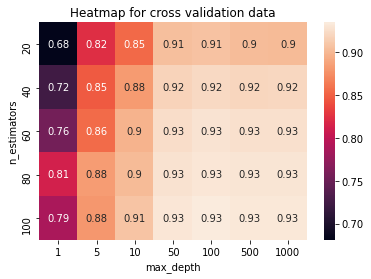

In [0]:
print ('-------------BEST DEPTH USING DIFFERENT RANGE OF ESTIMATORS')
result,best_depth,RF_Classiier=Random_Forest_Classifier(train_vectors,Y_Train,cv_vectors,Y_CV)

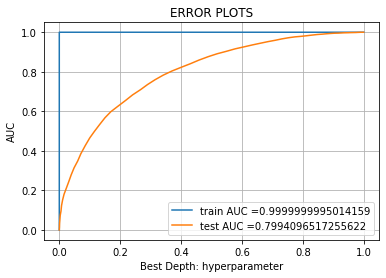

In [0]:
RFClassifier= RandomForestClassifier(random_state=None, class_weight ='balanced',max_depth = 50,n_estimators = 100)
clf=RFClassifier.fit(train_vectors,Y_Train)
pred_test_data=RFClassifier.predict(test_vectors)
y_train_predicted_prob = RFClassifier.predict_proba(train_vectors)[:,1]
y_test_predicted_prob=RFClassifier.predict_proba(test_vectors)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test, y_test_predicted_prob,pos_label='positive')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Best Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## TF-IDF Word2Vec Vectorization Technique using Random Forest 

In [0]:
model_Avgw2v = TfidfVectorizer()
X_Train_Avgw2v=model_Avgw2v.fit_transform(X_Train['Cleaned_text'].values)

In [0]:
X_Test_Avgw2v=model_Avgw2v.transform(X_Test['Cleaned_text'].values)
X_CV_Avgw2v=model_Avgw2v.transform(X_CV['Cleaned_text'].values)

In [0]:
dictionary = dict(zip(model_Avgw2v.get_feature_names(), list(model_Avgw2v.idf_)))

In [49]:
tfidf_feature=model_Avgw2v.get_feature_names()

tfidf_sent_vectors_train=[];
#final_tf_idf = [];
row=0;

for sent in tqdm(list_of_sent_train_avgw2v):
    sent_vec=np.zeros(50)
    weight_sum=0;
    for word in sent :
        if word in w2v_words_svm_train and word in tfidf_feature :
            vec=w2v_model_train.wv[word]
            #tf_idf=final_tf_idf[row,tfidf_feature.index(word)]
            tf_idf=dictionary[word]*(sent.count(word)/len(sent))
            sent_vec+=(vec*tf_idf)
            weight_sum+=tf_idf
    
    if weight_sum!=0:
        sent_vec/=weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row+=1

100%|██████████| 64000/64000 [13:27<00:00, 79.30it/s]


In [50]:
tfidf_sent_vectors_test=[];
#final_tf_idf = [];
row=0;

for sent in tqdm(list_of_sent_test_avgw2v):
    sent_vec=np.zeros(50)
    weight_sum=0;
    for word in sent :
        if word in w2v_words_svm_test and word in tfidf_feature :
            vec=w2v_model_test.wv[word]
            #tf_idf=final_tf_idf[row,tfidf_feature.index(word)]
            tf_idf=dictionary[word]*(sent.count(word)/len(sent))
            sent_vec+=(vec*tf_idf)
            weight_sum+=tf_idf
    
    if weight_sum!=0:
        sent_vec/=weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row+=1

100%|██████████| 20000/20000 [04:08<00:00, 80.46it/s]


-------------BEST DEPTH USING DIFFERENT RANGE OF ESTIMATORS
0.8817480033471647
{'max_depth': 100, 'n_estimators': 100}


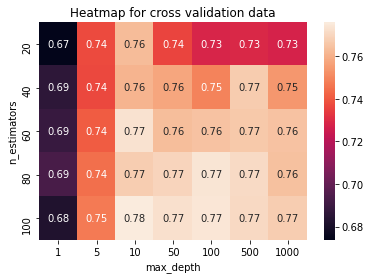

In [0]:
print ('-------------BEST DEPTH USING DIFFERENT RANGE OF ESTIMATORS')
result,best_depth,RF_Classiier=Random_Forest_Classifier(tfidf_sent_vectors_train,Y_Train,tfidf_sent_vectors_test,Y_Test)

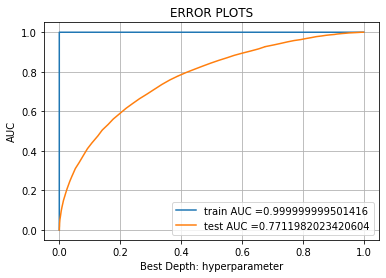

In [0]:
RFClassifier= RandomForestClassifier(random_state=None, class_weight ='balanced',max_depth = 100,n_estimators = 100)
clf=RFClassifier.fit(tfidf_sent_vectors_train,Y_Train)
pred_test_data=RFClassifier.predict(tfidf_sent_vectors_test)
y_train_predicted_prob = RFClassifier.predict_proba(tfidf_sent_vectors_train)[:,1]
y_test_predicted_prob=RFClassifier.predict_proba(tfidf_sent_vectors_test)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test, y_test_predicted_prob,pos_label='positive')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Best Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## PRETTY TABLE FOR RANDOM FOREST

In [0]:
pip install -U PTable

  Created wheel for PTable: filename=PTable-0.9.2-cp36-none-any.whl size=22908 sha256=92b2471788d31ed83df5850fc38025cd32f6193e831bdbebf306209194800078
  Stored in directory: /root/.cache/pip/wheels/22/cc/2e/55980bfe86393df3e9896146a01f6802978d09d7ebcba5ea56
Successfully built PTable


In [0]:
from prettytable import PrettyTable

x= PrettyTable()
x.field_names = ["Vectorizer" , "Hyperparameter(Best Depth)", "n-estimators","AUC"]
x.add_row(["Bag Of Words",100,100,0.9299])
x.add_row(["Tf-Idf",100,100,0.9265])
x.add_row(["Avg Word2Vec",50,100,0.9072])
x.add_row(["Tf-Idf Word2Vec",100,100,0.8817])
print(x)

+-----------------+----------------------------+--------------+--------+
|    Vectorizer   | Hyperparameter(Best Depth) | n-estimators |  AUC   |
+-----------------+----------------------------+--------------+--------+
|   Bag Of Words  |            100             |     100      | 0.9299 |
|      Tf-Idf     |            100             |     100      | 0.9265 |
|   Avg Word2Vec  |             50             |     100      | 0.9072 |
| Tf-Idf Word2Vec |            100             |     100      | 0.8817 |
+-----------------+----------------------------+--------------+--------+


#*GRADIENT BOOSTING ALGORITHM - XGBOOST*

In [0]:
pip install xgboost

## APPLY BAG OF WORDS VECTORIZATION TECHNIQUE USING GBDT TO FIND THE BEST DEPTH(HYPERPARAMETER)

In [0]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import cross_val_score
import xgboost as xgb


max_depth = [1,5,10,50,100,500,1000]
n_estimators =  [20,40,60,80,100] 
def XGBoost_Classifier(x_training_data,y_training_data,x_cv_training,y_cv_training):
  grid_params = { 'max_depth' : max_depth, 
                  'n_estimators' :n_estimators                  
                 }
  Classifier_XGBoost = xgb.XGBClassifier(random_state=0, booster='gbtree')
  clf=GridSearchCV(Classifier_XGBoost,grid_params,scoring='roc_auc',return_train_score=True,cv=3,n_jobs=-1)
  clf.fit(x_training_data,y_training_data)
  results = pd.DataFrame.from_dict(clf.cv_results_)
  results = results.sort_values(['param_max_depth'])
  results = results.sort_values(['param_n_estimators'])
  train_auc= results['mean_train_score']
  train_auc_std= results['std_train_score']
  cv_auc = results['mean_test_score'] 
  cv_auc_std= results['std_test_score']
  best_depth =  results['param_max_depth']   
  best_estimators =  results['param_n_estimators']   
  print(clf.best_score_)
  print(clf.best_params_) 
  Build_HeatMap(max_depth,n_estimators,x_training_data,y_training_data,x_cv_training,y_cv_training) 
  return results,clf,Classifier_XGBoost

-------------BEST DEPTH---------------
0.928610806402034
{'max_depth': 100, 'n_estimators': 100}


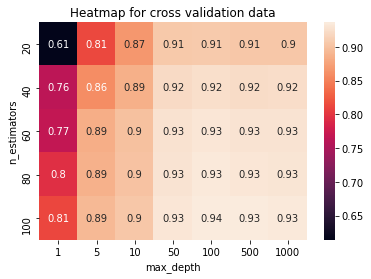

In [32]:
print ('-------------BEST DEPTH---------------')
result,best_depth,XGBoostClassiier=XGBoost_Classifier(X_Train_data_bow,Y_Train,X_CV_data_bow,Y_CV)

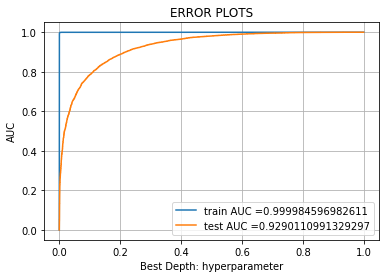

In [34]:
from sklearn.metrics import roc_curve, auc

GBDTClassifier= xgb.XGBClassifier(random_state=0,max_depth = 100,n_estimators = 100,booster='gbtree')
clf=GBDTClassifier.fit(X_Train_data_bow,Y_Train)
pred_test_data=GBDTClassifier.predict(X_Test_data_bow)
y_train_predicted_prob = GBDTClassifier.predict_proba(X_Train_data_bow)[:,1]
y_test_predicted_prob=GBDTClassifier.predict_proba(X_Test_data_bow)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test, y_test_predicted_prob,pos_label='positive')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Best Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

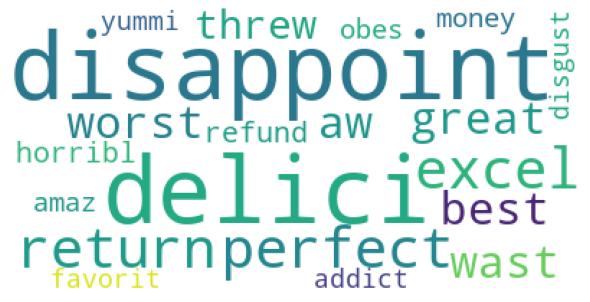

In [35]:
feature_names = count_vector.get_feature_names()
display_data=''
coef=GBDTClassifier.feature_importances_
features=np.argsort(coef)[::-1] 

for i in features[0:20]:
  display_data+=feature_names[i]
  display_data+=' '

from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white').generate(display_data)
plt.figure(figsize=(8,8),facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()

## APPLY TF-IDF VECTORIZATION TECHNIQUE USING XGBOOST TO FIND BEST HYPERPARAMETER

-------------BEST DEPTH---------------
0.9247632454806857
{'max_depth': 50, 'n_estimators': 100}


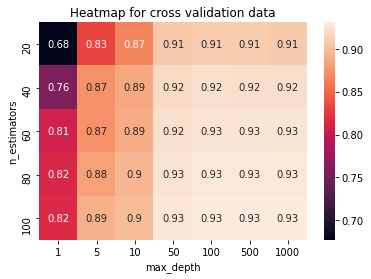

In [30]:
print ('-------------BEST DEPTH---------------')
result,best_depth,XGBoostClassiier=XGBoost_Classifier(X_Train_data_tfidf,Y_Train,X_CV_data_tfidf,Y_CV)

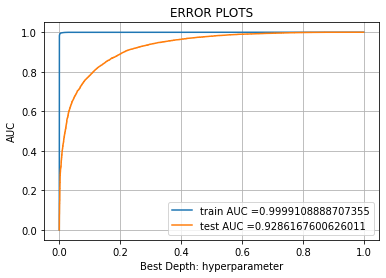

In [31]:
from sklearn.metrics import roc_curve, auc

GBDTClassifier= xgb.XGBClassifier(random_state=0,max_depth = 50,n_estimators = 100,booster='gbtree')
clf=GBDTClassifier.fit(X_Train_data_tfidf,Y_Train)
pred_test_data=GBDTClassifier.predict(X_Test_data_tfidf)
y_train_predicted_prob = GBDTClassifier.predict_proba(X_Train_data_tfidf)[:,1]
y_test_predicted_prob=GBDTClassifier.predict_proba(X_Test_data_tfidf)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test, y_test_predicted_prob,pos_label='positive')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Best Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

#### FIND THE IMPORTANT FEATURES AND PRINT THEM USING WORD CLOUD

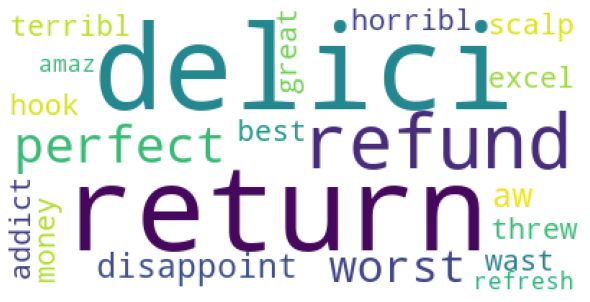

In [32]:
feature_names = tfidf_vector.get_feature_names()
display_data=''
coef=GBDTClassifier.feature_importances_
features=np.argsort(coef)[::-1] 

for i in features[0:20]:
  display_data+=feature_names[i]
  display_data+=' '

from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white').generate(display_data)
plt.figure(figsize=(8,8),facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()

## Avg Word2Vec Vectorization Technique using XGBoost Algorithm

In [0]:
XGBoost_Train_AvgWord2Vec=np.array(train_vectors)
XGBoost_Test_AvgWord2Vec = np.array(test_vectors)
XGBoost_CV_AvgWord2Vec = np.array(cv_vectors)

-------------BEST DEPTH USING DIFFERENT RANGE OF ESTIMATORS
0.9186298659126494
{'max_depth': 10, 'n_estimators': 100}


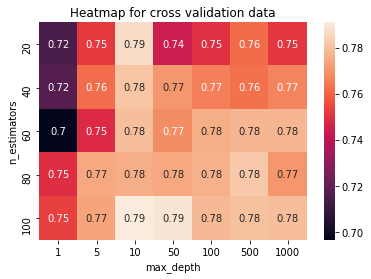

In [44]:
print ('-------------BEST DEPTH USING DIFFERENT RANGE OF ESTIMATORS')
result,best_depth,XGBoostClassiier=XGBoost_Classifier(XGBoost_Train_AvgWord2Vec,Y_Train,XGBoost_CV_AvgWord2Vec,Y_CV)

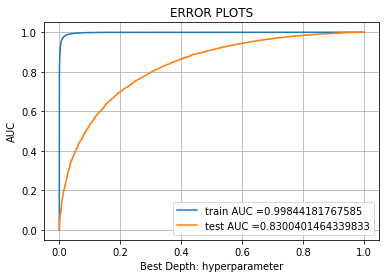

In [45]:
from sklearn.metrics import roc_curve, auc

GBDTClassifier= xgb.XGBClassifier(random_state=0,max_depth = 10,n_estimators = 100,booster='gbtree')
clf=GBDTClassifier.fit(XGBoost_Train_AvgWord2Vec,Y_Train)
pred_test_data=GBDTClassifier.predict(XGBoost_Test_AvgWord2Vec)
y_train_predicted_prob = GBDTClassifier.predict_proba(XGBoost_Train_AvgWord2Vec)[:,1]
y_test_predicted_prob=GBDTClassifier.predict_proba(XGBoost_Test_AvgWord2Vec)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test, y_test_predicted_prob,pos_label='positive')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Best Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## TF-IDF Word2Vec Vectorization Technique using XGBoost Algorithm

In [0]:
XGBoost_Train_TfidfWord2Vec=np.array(tfidf_sent_vectors_train)
XGBoost_Test_TfidfWord2Vec = np.array(tfidf_sent_vectors_test)

-------------BEST DEPTH USING DIFFERENT RANGE OF ESTIMATORS
0.8986430183498193
{'max_depth': 10, 'n_estimators': 100}


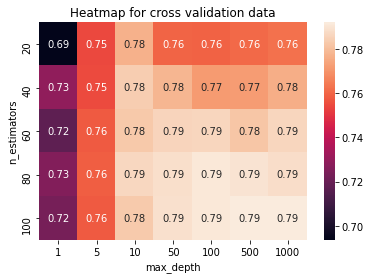

In [52]:
print ('-------------BEST DEPTH USING DIFFERENT RANGE OF ESTIMATORS')
result,best_depth,XGBoostClassiier=XGBoost_Classifier(XGBoost_Train_TfidfWord2Vec,Y_Train,XGBoost_Test_TfidfWord2Vec,Y_Test)

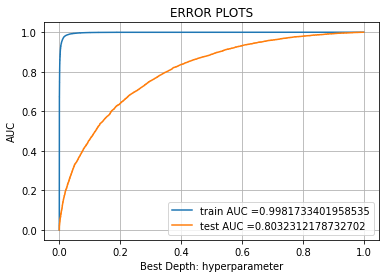

In [53]:
from sklearn.metrics import roc_curve, auc

GBDTClassifier= xgb.XGBClassifier(random_state=0,max_depth = 10,n_estimators = 100,booster='gbtree')
clf=GBDTClassifier.fit(XGBoost_Train_TfidfWord2Vec,Y_Train)
pred_test_data=GBDTClassifier.predict(XGBoost_Test_TfidfWord2Vec)
y_train_predicted_prob = GBDTClassifier.predict_proba(XGBoost_Train_TfidfWord2Vec)[:,1]
y_test_predicted_prob=GBDTClassifier.predict_proba(XGBoost_Test_TfidfWord2Vec)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test, y_test_predicted_prob,pos_label='positive')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Best Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## PRETTY TABLE FOR XGBOOST 

In [54]:
from prettytable import PrettyTable

x= PrettyTable()
x.field_names = ["Vectorizer" , "Hyperparameter(Best Depth)", "n-estimators","AUC"]
x.add_row(["Bag Of Words",100,100,0.9286])
x.add_row(["Tf-Idf",50,100,0.9247])
x.add_row(["Avg Word2Vec",10,100,0.9186])
x.add_row(["Tf-Idf Word2Vec",10,100,0.8986])
print(x)

+-----------------+----------------------------+--------------+--------+
|    Vectorizer   | Hyperparameter(Best Depth) | n-estimators |  AUC   |
+-----------------+----------------------------+--------------+--------+
|   Bag Of Words  |            100             |     100      | 0.9286 |
|      Tf-Idf     |             50             |     100      | 0.9247 |
|   Avg Word2Vec  |             10             |     100      | 0.9186 |
| Tf-Idf Word2Vec |             10             |     100      | 0.8986 |
+-----------------+----------------------------+--------------+--------+


### CONCLUSION 
###BY LOOKING AT THE TABLE FOR RANDOM FOREST AND XGBOOST , TF-IDF VECTORIZATION PERFORMS WELL WITH AUC OF 0.9247 HAVING BEST DEPTH AS 50